<a href="https://colab.research.google.com/github/cbg11/Playing-2048-Game-Using-RL-Agent/blob/main/2048_with_TD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import pickle
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
class Game:
    def __init__(self):
        self.board = np.zeros((4, 4), dtype=np.int32)
        self.score = 0
        self.game_over = False
        self.add_tile()
        self.add_tile()

    def add_tile(self):
        empty_cells = np.where(self.board == 0)
        if len(empty_cells[0]) == 0:
            return
        idx = random.choice(range(len(empty_cells[0])))
        value = 2 if random.random() < 0.9 else 4
        self.board[empty_cells[0][idx], empty_cells[1][idx]] = value

    def move(self, direction):
        if direction == 'left':
            self.board, moved, reward = move_left(self.board)
        elif direction == 'right':
            self.board, moved, reward = move_right(self.board)
        elif direction == 'up':
            self.board, moved, reward = move_up(self.board)
        elif direction == 'down':
            self.board, moved, reward = move_down(self.board)

        if moved:
            self.add_tile()
            self.score += reward
        if (np.count_nonzero(self.board) == 16) and (np.all(self.board[:, :-1] != self.board[:, 1:]) and np.all(self.board[:-1, :] != self.board[1:, :])):
            self.game_over = True
        return moved, reward
    def highest_tile(self):
      return max(max(row) for row in self.board)


In [4]:
def move_left(board):
  moved = False
  score = 0
  for row in range(4):
    merged = np.zeros((4,), dtype=bool)
    for col in range(1, 4):
      if board[row, col] == 0:
        continue
      for i in range(col):
        if board[row, i] == 0:
          board[row, i] = board[row, col]
          board[row, col] = 0
          moved = True
          break
        elif board[row, i] == board[row, col] and not merged[i]:
          board[row, i] *= 2
          board[row, col] = 0
          merged[i] = True
          moved = True
          score += board[row, i]
          break
  return board, moved, score

def move_right(board):
  board, moved, score = move_left(np.fliplr(board))
  return np.fliplr(board), moved, score
    
def move_up(board):
  board, moved, score = move_left(board.T)
  return board.T, moved, score

def move_down(board):
  board, moved, score = move_right(board.T)
  return board.T, moved, score

In [5]:
class TDAgent:
    def __init__(self, n, alpha=1.0, gamma=0.99, epsilon=1.0):
        self.n = n  # N-tuple length
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.q_table = {}  # Q-value table
    
    def preprocess(self, board):
        # Convert the board to a 1D array and take the logarithm
        return np.log2(np.maximum(1, board)).reshape(-1)
    
    def get_state_action_pairs(self, state):
        # Generate all possible N-tuples for the given state
        pairs = []
        for i in range(len(state) - self.n + 1):
            for j in range(self.n):
                pairs.append((tuple(state[i:i+self.n]), j))
        return pairs
    
    def get_q_value(self, state, action):
        # Look up the Q-value for the given state-action pair
        key = (tuple(state), action)
        if key in self.q_table:
            return self.q_table[key]
        else:
            return 0
    
    def update_q_value(self, state, action, reward, next_state):
        # Update the Q-value for the given state-action pair using TD learning
        td_target = reward + self.gamma * max(self.get_q_value(next_state, a) for a in range(4))
        td_error = td_target - self.get_q_value(state, action)
        key = (tuple(state), action)
        if key in self.q_table:
            self.q_table[key] += self.alpha * td_error
        else:
            self.q_table[key] = self.alpha * td_error
    
    def act(self, state, epsilon = None):
        # Choose an action based on the given state using epsilon-greedy exploration
        if epsilon == None:
          epsilon = self.epsilon
        else:
          epsilon = epsilon
        if np.random.rand() < epsilon:
            return np.random.choice(4)
        pairs = self.get_state_action_pairs(state)
        q_values = [self.get_q_value(state, action) for action in range(4)]
        max_q_value = max(q_values)
        best_pairs = [pair for pair in pairs if self.get_q_value(state, pair[1]) == max_q_value]
        return np.random.choice([pair[1] for pair in best_pairs])

    def train(self, num_episodes):
        for i in range(num_episodes):
            game = Game()
            highest_tile = 0
            while not game.game_over:
                state = self.preprocess(game.board)
                action = self.act(state)
                moved, reward = game.move(['left', 'up', 'right', 'down'][action])
                next_state = self.preprocess(game.board)
                self.update_q_value(state, action, reward, next_state)
            highest_tile = max(highest_tile, game.highest_tile())
            print('Episode {}: score={}, highest_tile={}'.format(i+1, game.score, highest_tile))
            if self.epsilon > 0.1:
              self.epsilon *= 0.999  # decrease exploration rate over time
            if self.alpha > 0.1:
              self.alpha *= 0.999  # decrease learning rate over time
            
            if i % 10000 == 0:
              self.save_model()

    def save_model(self, file_path='td_agent.pkl'):
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

In [6]:
# Path to save file
import pathlib
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/RL_Project

Mounted at /content/drive/
/content/drive/My Drive/RL_Project


In [ ]:
agent = TDAgent(n=4)
agent.train(num_episodes=5001)
agent.save_model('td_agent.pkl')

Streaming output truncated to the last 5000 lines.
Episode 2: score=26512, highest_tile=2048
Episode 3: score=16160, highest_tile=1024
Episode 4: score=11444, highest_tile=1024
Episode 5: score=27128, highest_tile=2048
Episode 6: score=14612, highest_tile=1024
Episode 7: score=7172, highest_tile=512
Episode 8: score=7524, highest_tile=512
Episode 9: score=25632, highest_tile=2048
Episode 10: score=32256, highest_tile=2048
Episode 11: score=12112, highest_tile=1024
Episode 12: score=12168, highest_tile=1024
Episode 13: score=15988, highest_tile=1024
Episode 14: score=23360, highest_tile=2048
Episode 15: score=16348, highest_tile=1024
Episode 16: score=7120, highest_tile=512
Episode 17: score=3176, highest_tile=256
Episode 18: score=16420, highest_tile=1024
Episode 19: score=16168, highest_tile=1024
Episode 20: score=27200, highest_tile=2048
Episode 21: score=12356, highest_tile=1024
Episode 22: score=14464, highest_tile=1024
Episode 23: score=6516, highest_tile=512
Episode 24: score=336

In [7]:
if __name__ == '__main__':
    with open('td_agent.pkl', 'rb') as f:
      agent = pickle.load(f)
    num_trials = 100
    max_values = []
    avg_score = 0
    for i in range(num_trials):
        game = Game()
        while not game.game_over:
            state = agent.preprocess(game.board)
            action = agent.act(state, epsilon = 0)
            moved = game.move(['left', 'up', 'right', 'down'][action])
            while not moved:
              rand_num = action
              while rand_num == action:
                rand_num = random.randrange(4)
              moved = game.move(['left', 'up', 'right', 'down'][rand_num])
        max_values.append(game.highest_tile())
        avg_score += game.score
        print('Trial {}: score={}, highest_tile={}'.format(i+1, game.score, game.highest_tile()))
    avg_score /= num_trials
    print(f'Average score over {num_trials} trials: {avg_score}')


Trial 1: score=15276, highest_tile=1024
Trial 2: score=5416, highest_tile=512
Trial 3: score=32232, highest_tile=2048
Trial 4: score=16376, highest_tile=1024
Trial 5: score=23064, highest_tile=2048
Trial 6: score=15352, highest_tile=1024
Trial 7: score=16228, highest_tile=1024
Trial 8: score=21816, highest_tile=2048
Trial 9: score=27252, highest_tile=2048
Trial 10: score=11848, highest_tile=1024
Trial 11: score=14188, highest_tile=1024
Trial 12: score=7316, highest_tile=512
Trial 13: score=6844, highest_tile=512
Trial 14: score=12188, highest_tile=1024
Trial 15: score=7540, highest_tile=512
Trial 16: score=15412, highest_tile=1024
Trial 17: score=11720, highest_tile=1024
Trial 18: score=13468, highest_tile=1024
Trial 19: score=27364, highest_tile=2048
Trial 20: score=12304, highest_tile=1024
Trial 21: score=3432, highest_tile=256
Trial 22: score=7760, highest_tile=512
Trial 23: score=14908, highest_tile=1024
Trial 24: score=11808, highest_tile=1024
Trial 25: score=23196, highest_tile=2

In [28]:
count = 0
for i in max_values:
  if i == 2048:
    count += 1
count 

14

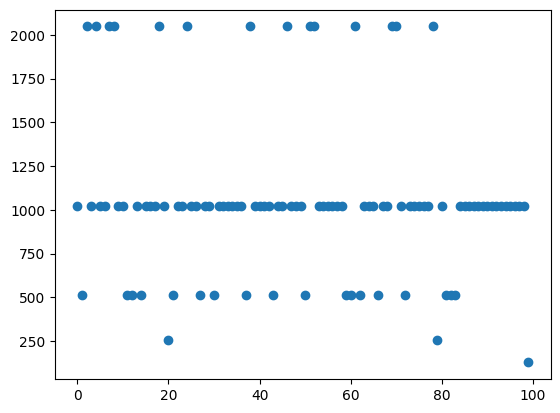

In [29]:
def plot_list(list_to_plot):
    x = range(len(list_to_plot))
    y = list_to_plot
    plt.scatter(x, y)
    plt.show()
plot_list(max_values)

In [37]:
# Define a function to display the game board and score
def display_board(score, action, grid):
    print(f"\033[1m" + "Score: ", score, "\t Action: "+ action+ "\033[0m")
    print("+-------+-------+-------+-------+\n"
          "|\t|\t|\t|\t|\n"
          "|  {}\t|  {}\t|  {}\t|  {}\t|\n"
          "|\t|\t|\t|\t|\n"
          "+-------+-------+-------+-------+\n"
          "|\t|\t|\t|\t|\n"
          "|  {}\t|  {}\t|  {}\t|  {}\t|\n"
          "|\t|\t|\t|\t|\n"
          "+-------+-------+-------+-------+\n"
          "|\t|\t|\t|\t|\n"
          "|  {}\t|  {}\t|  {}\t|  {}\t|\n"
          "|\t|\t|\t|\t|\n"
          "+-------+-------+-------+-------+\n"
          "|\t|\t|\t|\t|\n"
          "|  {}\t|  {}\t|  {}\t|  {}\t|\n"
          "|\t|\t|\t|\t|\n"
          "+-------+-------+-------+-------+\n".format(*[x if x != 0 else "" for row in grid for x in row]))
def play():
  game = Game()
  with open('td_agent.pkl', 'rb') as f:
    agent = pickle.load(f)
  while not game.game_over:
    state = agent.preprocess(game.board)
    action = agent.act(state, epsilon = 0)
    act =['left', 'up', 'right', 'down'][action]
    moved, reward = game.move(act)
    while not moved:
      rand_num = action
      while rand_num == action:
        rand_num = random.randrange(4)
      action = rand_num
      act =['left', 'up', 'right', 'down'][action]
      moved, reward = game.move(act)
    clear_output(wait=True)
    display_board(game.score, act, game.board)
    time.sleep(2)


In [36]:
play()

Score:  22792 	 Action: up
+-------+-------+-------+-------+
|	|	|	|	|
|  4	|  16	|  64	|  4	|
|	|	|	|	|
+-------+-------+-------+-------+
|	|	|	|	|
|  8	|  32	|  4	|  2	|
|	|	|	|	|
+-------+-------+-------+-------+
|	|	|	|	|
|  4	|  64	|  256	|  16	|
|	|	|	|	|
+-------+-------+-------+-------+
|	|	|	|	|
|  2	|  4	|  2048	|  8	|
|	|	|	|	|
+-------+-------+-------+-------+

